#Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras as ks
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
print(tf.__version__)

2.8.0


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset

 99% 741M/750M [00:04<00:00, 112MB/s]
100% 750M/750M [00:05<00:00, 157MB/s]


In [ ]:
!unzip -q "/content/stanford-dogs-dataset.zip"

In [ ]:
!unzip -q '/content/drive/Shareddrives/MIRCV Project/mirflickr25k.zip'

In [5]:
!unzip -q '/content/drive/Shareddrives/MIRCV Project/test.zip'

In [7]:
ds_test = image_dataset_from_directory('/content/test',
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=False,
                                       seed=42,
                                       )

Found 2058 files belonging to 120 classes.


In [ ]:
fpath = '/content/images/Images'
categories = os.listdir(fpath)

In [6]:
imgsize = 224
batch_size = 64
n_classes = 120

In [ ]:
ds_train = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='training',
                                       )

val_test = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='validation',
                                       )

ds = val_test.shuffle(64, reshuffle_each_iteration=False, seed=45)
ds_test = ds.skip(32)
ds_val = ds.take(32)

#ds_test.shuffle(32, reshuffle_each_iteration=False)
#ds_val.shuffle(32, reshuffle_each_iteration=False)




Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
distractor_images = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/mirflickr25k/mirflickr',
    image_size = (imgsize, imgsize),
    batch_size = batch_size,
    seed=42,
    labels=None,
    label_mode=None)

Found 25000 files belonging to 1 classes.


In [ ]:
import numpy as np

print(len(np.concatenate([i for x, i in ds_val], axis=0))) #count number of elements in ds_val

print(len(np.concatenate([i for x, i in ds_test], axis=0)))

2048
2068


#Utilities

In [8]:
def evaluate_model (model):
  '''
  evaluate_model is used to show some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(ds_test)
  y_pred = np.argmax(y_score, axis=1)
  print(y_pred)
  #y_true = tf.concat([np.argmax(labels_batch, axis=1) for data_batch, labels_batch in ds_test], axis = 0)
  true_categories = tf.concat([y for x, y in ds_test], axis = 0).numpy()
  true_categories_argmax = np.argmax(true_categories, axis = 1)
  print(true_categories_argmax)
  #confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  #print("Confusion matrix: ")
  #print(confusion_matrix)
  print("Classification report: ")
  print(metrics.classification_report(true_categories_argmax,y_pred,digits = 4))

In [ ]:
def fine_tuning(num_of_blocks=1):
    if num_of_blocks < 1:
        num_of_blocks = 1

    res = conv_base()
    res.trainable = True
    set_trainable = False

    
    if num_of_blocks == 1:
        block_name = 'conv4_block19_out'
    elif num_of_blocks == 2:
        block_name = 'conv4_block10_out'
    elif num_of_blocks == 3:
        block_name = 'conv4_block6_out'
    elif num_of_blocks == 4:
        block_name = 'conv5_block1_out'
    else:
        block_name = 'conv5_block2_out'

    for layer in res.layers:
        if layer.name == block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    return res

In [ ]:
def finetuned_resnet101(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1, fill_mode="nearest"),
        layers.RandomZoom(height_factor=(0.0, -0.1)),
    ]
)

In [ ]:
def input(data_augmentation=None):
    inputs = ks.Input(shape=(224, 224, 3))
    x = ks.applications.resnet50.preprocess_input(inputs)
    if data_augmentation is not None:
        x = data_augmentation(x)
    return x

In [ ]:
##modeling
def conv_base():
  base_model = ResNet101(include_top=False,
                    input_shape = (imgsize,imgsize,3),
                    weights = 'imagenet',
                    pooling='avg')

  base_model.trainable = False
  base_model.summary()
  return base_model

# ResNet101 Features extraction

In [ ]:
def resnet101_feature_extraction(data_augmentation=None):
    inputs = input(data_augmentation)
    outputs = conv_base()(inputs)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet101_feature_extraction()

171458560/171446536 [==============================] - 2s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
Total params: 42,658,176
Trainable params: 0
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:
features = resnet101_feature_extraction().predict(ds_train, batch_size=batch_size, verbose=True)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
features.shape

(16464, 2048)

Save features:

In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet101/training/features_tr.npy', features)

Features for test set:

In [ ]:
features = model.predict(ds_test, batch_size=batch_size, verbose=True)

33/33 [==============================] - 31s 652ms/step


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet101/test/features_ts.npy', features)

Features for distractor set:

In [ ]:
features = model.predict(distractor_images, batch_size=batch_size, verbose=True)

391/391 [==============================] - 257s 646ms/step


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet101/distractor/features_dis.npy', features)

#Predictions

In [ ]:
base_model = conv_base()
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(224, 224, 3)))
model.add(data_augmentation)
model.add(base_model)
model.add(Dense(n_classes,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = [ES])

Epoch 1/40
258/258 [==============================] - 232s 859ms/step - loss: 2.5395 - accuracy: 0.3837 - val_loss: 1.5188 - val_accuracy: 0.5859
Epoch 2/40
258/258 [==============================] - 223s 861ms/step - loss: 1.4952 - accuracy: 0.5892 - val_loss: 1.3918 - val_accuracy: 0.6211
Epoch 3/40
258/258 [==============================] - 223s 861ms/step - loss: 1.2442 - accuracy: 0.6493 - val_loss: 1.3848 - val_accuracy: 0.6260
Epoch 4/40
258/258 [==============================] - 222s 859ms/step - loss: 1.0807 - accuracy: 0.6866 - val_loss: 1.3551 - val_accuracy: 0.6274
Epoch 5/40
258/258 [==============================] - 223s 862ms/step - loss: 0.9610 - accuracy: 0.7162 - val_loss: 1.3218 - val_accuracy: 0.6431
Epoch 6/40
258/258 [==============================] - 223s 862ms/step - loss: 0.8979 - accuracy: 0.7332 - val_loss: 1.3355 - val_accuracy: 0.6416
Epoch 7/40
258/258 [==============================] - 223s 859ms/step - loss: 0.7998 - accuracy: 0.7609 - val_loss: 1.3838 -

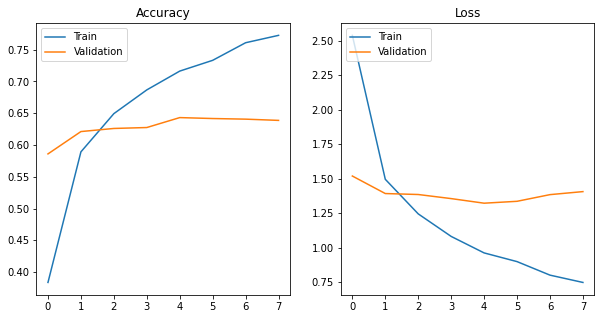

Best Validation Accuracy: 64.306640625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [9]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/ResNet101_exp0.h5')

In [10]:
evaluate_model(model)

[  0   0   0 ... 119 119  94]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5000    0.6923    0.5806        13
           1     0.8621    0.9259    0.8929        27
           2     0.9048    0.8636    0.8837        22
           3     0.7500    0.5000    0.6000        18
           4     0.6957    0.7273    0.7111        22
           5     0.8571    0.6316    0.7273        19
           6     1.0000    0.9412    0.9697        17
           7     0.8000    0.5714    0.6667        14
           8     0.3333    0.1765    0.2308        17
           9     0.8788    0.9355    0.9062        31
          10     0.6471    0.5789    0.6111        19
          11     0.4848    0.7273    0.5818        22
          12     0.6875    0.6471    0.6667        17
          13     0.5333    0.5333    0.5333        15
          14     0.7778    0.7778    0.7778        18
          15     0.5000    0.5833    0.5385        

In [11]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 651ms/step - loss: 1.3428 - accuracy: 0.6380


[1.3427817821502686, 0.6379980444908142]

In [ ]:
tf.keras.models.save_model(model, filepath='/content/drive/Shareddrives/MIRCV Project/ResNet101/ResNet101_exp0.h5')

#Fine tuning from conv4_block19_out




In [ ]:
model = finetuned_resnet101(120, num_of_blocks=1, data_augmentation=data_augmentation)
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model1.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 299s 1s/step - loss: 1.9907 - accuracy: 0.4676 - val_loss: 1.8778 - val_accuracy: 0.4761
Epoch 2/40
258/258 [==============================] - 285s 1s/step - loss: 0.8255 - accuracy: 0.7518 - val_loss: 1.4875 - val_accuracy: 0.5811
Epoch 3/40
258/258 [==============================] - 278s 1s/step - loss: 0.3532 - accuracy: 0.8989 - val_loss: 1.5250 - val_accuracy: 0.6152
Epoch 4/40
258/258 [==============================] - 278s 1s/step - loss: 0.1496 - accuracy: 0.9624 - val_loss: 1.7467 - val_accuracy: 0.5918
Epoch 5/40
258/258 [==============================] - 277s 1s/step - loss: 0.1122 - accuracy: 0.9731 - val_loss: 1.8147 - val_accuracy: 0.5957
Epoch 6/40
258/258 [==============================] - 277s 1s/step - loss: 0.0831 - accuracy: 0.9798 - val_loss: 1.8014 - val_accuracy: 0.6089
Epoch 7/40
258/258 [==============================] - 273s 1s/step - loss: 0.0725 - accuracy: 0.9824 - val_loss: 1.6495 - val_accuracy: 0.6250

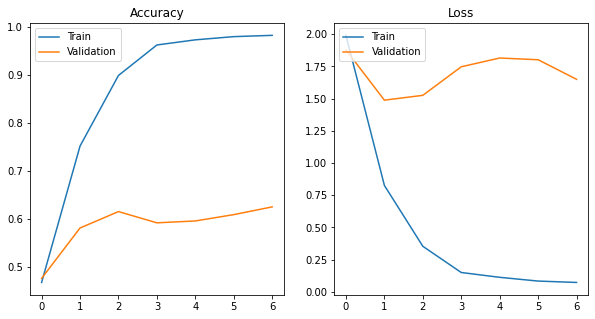

Best Validation Accuracy: 62.5%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [12]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/model1.h5')

In [13]:
evaluate_model(model)

[  0   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.3182    0.5385    0.4000        13
           1     0.6250    0.9259    0.7463        27
           2     1.0000    0.2727    0.4286        22
           3     0.3091    0.9444    0.4658        18
           4     0.8182    0.4091    0.5455        22
           5     0.5652    0.6842    0.6190        19
           6     0.5769    0.8824    0.6977        17
           7     0.6667    0.2857    0.4000        14
           8     0.6667    0.1176    0.2000        17
           9     0.5000    0.9677    0.6593        31
          10     1.0000    0.1579    0.2727        19
          11     0.9333    0.6364    0.7568        22
          12     0.8571    0.3529    0.5000        17
          13     0.9091    0.6667    0.7692        15
          14     1.0000    0.1667    0.2857        18
          15     0.5000    0.2500    0.3333        

In [14]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 649ms/step - loss: 1.5327 - accuracy: 0.5666


[1.5327074527740479, 0.5665695071220398]

#Fine tuning from conv4_block10_out

In [ ]:
model = finetuned_resnet101(120, num_of_blocks=2, data_augmentation=data_augmentation)
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_19[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 386s 1s/step - loss: 2.4541 - accuracy: 0.3650 - val_loss: 8.5499 - val_accuracy: 0.2388
Epoch 2/40
258/258 [==============================] - 370s 1s/step - loss: 1.1084 - accuracy: 0.6668 - val_loss: 1.5452 - val_accuracy: 0.5571
Epoch 3/40
258/258 [==============================] - 361s 1s/step - loss: 0.5141 - accuracy: 0.8461 - val_loss: 1.6873 - val_accuracy: 0.5532
Epoch 4/40
258/258 [==============================] - 361s 1s/step - loss: 0.2407 - accuracy: 0.9326 - val_loss: 1.8395 - val_accuracy: 0.5474
Epoch 5/40
258/258 [==============================] - 361s 1s/step - loss: 0.1260 - accuracy: 0.9682 - val_loss: 1.6540 - val_accuracy: 0.5977
Epoch 6/40
258/258 [==============================] - 360s 1s/step - loss: 0.0903 - accuracy: 0.9784 - val_loss: 1.8935 - val_accuracy: 0.5854
Epoch 7/40
258/258 [==============================] - 360s 1s/step - loss: 0.0781 - accuracy: 0.9803 - val_loss: 1.9942 - val_accuracy: 0.5552

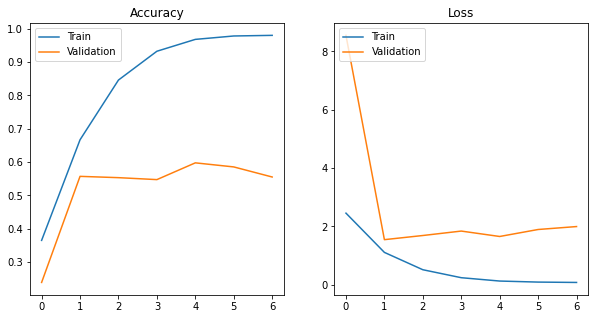

Best Validation Accuracy: 59.765625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [15]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/model2.h5')

In [16]:
evaluate_model(model)

[  0   1   0 ...  95 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.7500    0.4615    0.5714        13
           1     0.5510    1.0000    0.7105        27
           2     0.6923    0.8182    0.7500        22
           3     0.5000    0.6111    0.5500        18
           4     0.6471    0.5000    0.5641        22
           5     0.4815    0.6842    0.5652        19
           6     0.9000    0.5294    0.6667        17
           7     0.7143    0.3571    0.4762        14
           8     0.5000    0.1176    0.1905        17
           9     0.5472    0.9355    0.6905        31
          10     0.4722    0.8947    0.6182        19
          11     0.4651    0.9091    0.6154        22
          12     0.4545    0.8824    0.6000        17
          13     0.4583    0.7333    0.5641        15
          14     0.8235    0.7778    0.8000        18
          15     0.4000    0.1667    0.2353        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 649ms/step - loss: 1.6018 - accuracy: 0.5578


[1.60178542137146, 0.557823121547699]

#Fine tuning from conv4_block6_out

In [ ]:
model = finetuned_resnet101(120, num_of_blocks=3, data_augmentation=data_augmentation)
model.summary()

171458560/171446536 [==============================] - 7s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 439s 2s/step - loss: 3.2460 - accuracy: 0.2122 - val_loss: 8.0401 - val_accuracy: 0.2163
Epoch 2/40
258/258 [==============================] - 410s 2s/step - loss: 1.6016 - accuracy: 0.5391 - val_loss: 1.8059 - val_accuracy: 0.4985
Epoch 3/40
258/258 [==============================] - 407s 2s/step - loss: 0.8621 - accuracy: 0.7427 - val_loss: 1.7302 - val_accuracy: 0.5117
Epoch 4/40
258/258 [==============================] - 405s 2s/step - loss: 0.4042 - accuracy: 0.8818 - val_loss: 1.7986 - val_accuracy: 0.5293
Epoch 5/40
258/258 [==============================] - 405s 2s/step - loss: 0.1941 - accuracy: 0.9469 - val_loss: 1.8782 - val_accuracy: 0.5381
Epoch 6/40
258/258 [==============================] - 406s 2s/step - loss: 0.1090 - accuracy: 0.9724 - val_loss: 2.0248 - val_accuracy: 0.5381


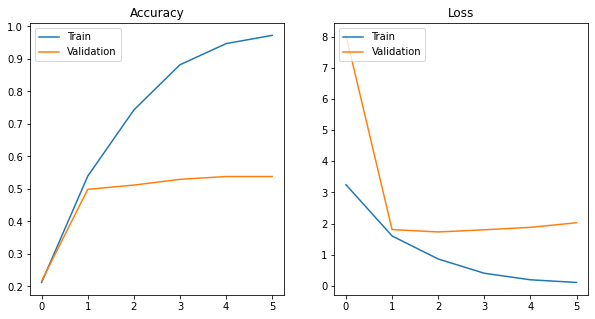

Best Validation Accuracy: 53.80859375%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [18]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/model3.h5')

In [19]:
evaluate_model(model)

[  0   0  99 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.3684    0.5385    0.4375        13
           1     0.6111    0.8148    0.6984        27
           2     1.0000    0.3182    0.4828        22
           3     0.5217    0.6667    0.5854        18
           4     0.8750    0.3182    0.4667        22
           5     0.5455    0.6316    0.5854        19
           6     0.6875    0.6471    0.6667        17
           7     0.5556    0.3571    0.4348        14
           8     0.0000    0.0000    0.0000        17
           9     0.8571    0.5806    0.6923        31
          10     0.4286    0.7895    0.5556        19
          11     0.5000    0.4091    0.4500        22
          12     0.5455    0.7059    0.6154        17
          13     0.9000    0.6000    0.7200        15
          14     0.4815    0.7222    0.5778        18
          15     0.2000    0.1667    0.1818        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 664ms/step - loss: 1.7272 - accuracy: 0.5228


[1.7272059917449951, 0.5228376984596252]

#Fine tuning from conv5_block1_out

In [ ]:
model = finetuned_resnet101(120, num_of_blocks=4, data_augmentation=data_augmentation)
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model4.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 232s 865ms/step - loss: 1.8838 - accuracy: 0.4953 - val_loss: 1.8530 - val_accuracy: 0.5283
Epoch 2/40
258/258 [==============================] - 228s 866ms/step - loss: 0.8911 - accuracy: 0.7307 - val_loss: 1.7571 - val_accuracy: 0.5312
Epoch 3/40
258/258 [==============================] - 227s 872ms/step - loss: 0.5275 - accuracy: 0.8380 - val_loss: 1.5248 - val_accuracy: 0.5933
Epoch 4/40
258/258 [==============================] - 222s 855ms/step - loss: 0.3107 - accuracy: 0.9044 - val_loss: 1.5810 - val_accuracy: 0.6104
Epoch 5/40
258/258 [==============================] - 225s 869ms/step - loss: 0.1704 - accuracy: 0.9511 - val_loss: 1.3996 - val_accuracy: 0.6499
Epoch 6/40
258/258 [==============================] - 224s 864ms/step - loss: 0.1197 - accuracy: 0.9688 - val_loss: 1.3560 - val_accuracy: 0.6680
Epoch 7/40
258/258 [==============================] - 223s 858ms/step - loss: 0.0999 - accuracy: 0.9758 - val_loss: 1.4161 -

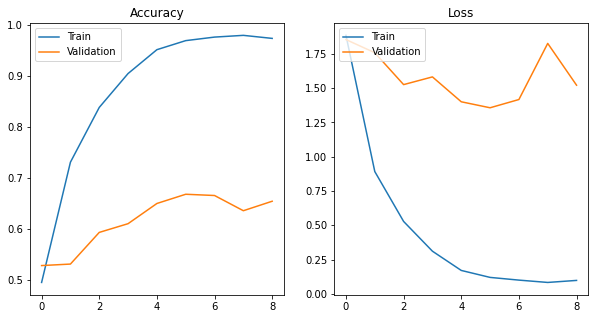

Best Validation Accuracy: 66.796875%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [21]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/model4.h5')

In [22]:
evaluate_model(model)

[  0   0   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.8182    0.6923    0.7500        13
           1     0.8929    0.9259    0.9091        27
           2     0.8333    0.6818    0.7500        22
           3     0.9231    0.6667    0.7742        18
           4     0.6667    0.5455    0.6000        22
           5     0.8125    0.6842    0.7429        19
           6     0.8889    0.9412    0.9143        17
           7     0.7778    0.5000    0.6087        14
           8     0.4444    0.2353    0.3077        17
           9     0.8788    0.9355    0.9062        31
          10     0.5312    0.8947    0.6667        19
          11     0.8947    0.7727    0.8293        22
          12     0.8667    0.7647    0.8125        17
          13     0.5000    0.8000    0.6154        15
          14     0.7083    0.9444    0.8095        18
          15     0.4000    0.3333    0.3636        

In [23]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 647ms/step - loss: 1.4133 - accuracy: 0.6545


[1.4132779836654663, 0.6545189619064331]

#Fine tuning from conv5_block2_out

In [ ]:
model = finetuned_resnet101(120, num_of_blocks=5, data_augmentation=data_augmentation)
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model5.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 223s 832ms/step - loss: 1.8745 - accuracy: 0.4957 - val_loss: 1.6357 - val_accuracy: 0.5830
Epoch 2/40
258/258 [==============================] - 215s 829ms/step - loss: 0.8737 - accuracy: 0.7343 - val_loss: 1.6043 - val_accuracy: 0.5845
Epoch 3/40
258/258 [==============================] - 213s 824ms/step - loss: 0.5260 - accuracy: 0.8362 - val_loss: 1.5519 - val_accuracy: 0.6060
Epoch 4/40
258/258 [==============================] - 214s 824ms/step - loss: 0.3146 - accuracy: 0.9032 - val_loss: 1.4242 - val_accuracy: 0.6455
Epoch 5/40
258/258 [==============================] - 213s 821ms/step - loss: 0.1815 - accuracy: 0.9509 - val_loss: 1.4196 - val_accuracy: 0.6509
Epoch 6/40
258/258 [==============================] - 214s 824ms/step - loss: 0.1257 - accuracy: 0.9688 - val_loss: 1.5770 - val_accuracy: 0.6362
Epoch 7/40
258/258 [==============================] - 216s 834ms/step - loss: 0.0796 - accuracy: 0.9826 - val_loss: 1.4568 -

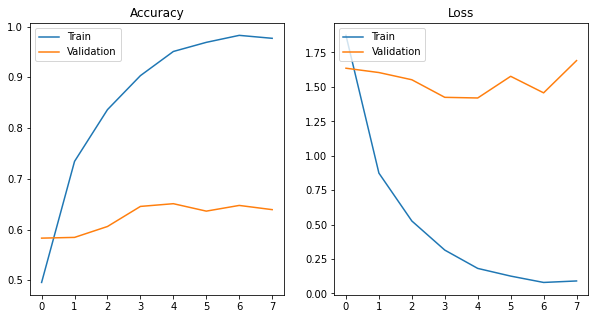

Best Validation Accuracy: 65.087890625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [24]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet101/model5.h5')

In [25]:
evaluate_model(model)

[  0   6   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.6667    0.4615    0.5455        13
           1     0.5641    0.8148    0.6667        27
           2     1.0000    0.6818    0.8108        22
           3     0.7857    0.6111    0.6875        18
           4     0.7273    0.7273    0.7273        22
           5     1.0000    0.2632    0.4167        19
           6     0.7273    0.9412    0.8205        17
           7     0.4545    0.7143    0.5556        14
           8     0.8571    0.3529    0.5000        17
           9     0.7568    0.9032    0.8235        31
          10     0.4688    0.7895    0.5882        19
          11     0.8333    0.4545    0.5882        22
          12     0.7222    0.7647    0.7429        17
          13     0.5652    0.8667    0.6842        15
          14     0.6842    0.7222    0.7027        18
          15     0.3125    0.4167    0.3571        

In [26]:
model.evaluate(ds_test)

33/33 [==============================] - 24s 649ms/step - loss: 1.4984 - accuracy: 0.6433


[1.498389482498169, 0.6433430314064026]